# Preparations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wot

import anndata as ad
# import mnnpy as mp
import scanpy as sc

import sklearn.neighbors as nb

In [2]:
# Data loading

FLE_COORDS_PATH ='data/fle_coords.txt'
FULL_DS_PATH = 'data/ExprMatrix.h5ad'
VAR_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = 'data/cell_days.txt'
GENE_SETS_PATH = 'data/gene_sets.gmx'
GENE_SET_SCORES_PATH = 'data/gene_set_scores.csv'
CELL_SETS_PATH = 'data/cell_sets.gmt'

coord_df = pd.read_csv(FLE_COORDS_PATH, index_col='id', sep='\t')
days_df = pd.read_csv(CELL_DAYS_PATH, index_col='id', sep='\t')

adata = wot.io.read_dataset(FULL_DS_PATH, obs=[CELL_DAYS_PATH])

In [3]:
days = adata.obs['day'].unique()[:-1]
indices = [adata.obs['day'].isin([day]) for day in days]
adatalist = [adata[index] for index in indices]

pcadata = np.load('adata_dim_400.npy')
pcadatalist = [pcadata[index] for index in indices]

In [5]:
indices[36].sum()

8110

In [4]:
import torch
torch.cuda.is_available()

True

# Verification of correctness of KNN method

In [ ]:
import sklearn.neighbors as nb
import pandas as pd
import numpy as np
import wot

def NNVerification(index_pair, n_neighbors=50, do_concatenate=True, FULL_DS_PATH='data/ExprMatrix.h5ad', CELL_DAYS_PATH='data/cell_days.txt', split_mode='day'):
    time_ref, time_new = index_pair
    assert time_new == time_ref + 1, 'Noncontiguous time indices.'
    mnn_path = f"pcadata/{time_ref}_{time_new}.csv"
    crt_path = f"pcadata/pcadata_contiguous_{time_ref}_{time_new}.npy"
    mnn_pair = pd.read_csv(mnn_path)
    crt_pcadata = np.load(crt_path, allow_pickle=True)
    # print(crt_pcadata)
    
    adata = wot.io.read_dataset(FULL_DS_PATH, obs=[CELL_DAYS_PATH])
    obs_unique = filter(None, adata.obs[split_mode].unique())
    adata_indices = [adata.obs[split_mode].isin([obs_uni_ele]) for obs_uni_ele in obs_unique]
    adatalist = [adata[index] for index in adata_indices]
    checkpoints = adata.obs[split_mode].unique()
    print(f"Time pair: day {checkpoints[time_ref]}, day {checkpoints[time_new]}")
    
    KNN = nb.NearestNeighbors(n_neighbors=n_neighbors)

    n_obs_ref = adata[adata.obs[split_mode].isin([checkpoints[time_ref]])].n_obs
    n_obs_new = adata[adata.obs[split_mode].isin([checkpoints[time_new]])].n_obs
    
    print(n_obs_ref)
    print(n_obs_new)
    pcadata_ref = pcadata_new = None
    if do_concatenate:
        pcadata_ref = crt_pcadata[0][:n_obs_ref]
        pcadata_new = crt_pcadata[0][n_obs_ref:]
    # print(crt_pcadata)
    # print(pcadata_ref)
    KNN.fit(pcadata_new)
    
    paired_ref_cell_indices = mnn_pair['ref cell'].unique()
    paired_new_cell_indices = mnn_pair['new cell'].unique()
    
    dists, knn_indices = KNN.kneighbors(pcadata_ref)
    intersection = []
    
    for paired_ref_cell_index in paired_ref_cell_indices:
        knn_set = set(knn_indices[paired_ref_cell_index])
        new_cell_indices = mnn_pair['ref cell'] == paired_ref_cell_index
        mnn_set = set(mnn_pair[new_cell_indices]['new cell'])
        intersection.append(len(knn_set & mnn_set) / len(mnn_set))
        
    intersection = np.array(intersection)
        
    print(f"Average intersection ratio: {np.average(intersection)}")
    
    unpaired_ref_cell_indices = [index for index in range(n_obs_ref) if index not in paired_ref_cell_indices]
    unpaired_new_cell_indices = [index for index in range(n_obs_new) if index not in paired_new_cell_indices]
    
    return intersection, unpaired_ref_cell_indices, unpaired_new_cell_indices
    

In [97]:
index_pair = (1, 2)
intersection, unpaired_ref_cells, unpaired_new_cells = NNVerification(index_pair)
np.count_nonzero(intersection > 0.5) / len(intersection)

Time pair: day 0.5, day 1.0
3449
3648
Average intersection ratio: 0.6392277810012297


0.6754731861198738

# Generate training pairs

Use KNN to generate initial pairs for those unmatched in MNN.

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

def gen_pairs_train(index_pair, unpaired_ref_cells, unpaired_new_cells):
    mnn_pair = pd.read_csv(f"pcadata/{index_pair[0]}_{index_pair[1]}.csv")
    mnn_pair_ref_new_pair_indices = torch.from_numpy(np.stack((mnn_pair['ref cell'], mnn_pair['new cell']), axis=0)).T

    crt_pcadata = np.load(f'pcadata/pcadata_contiguous_{index_pair[0]}_{index_pair[1]}.npy', allow_pickle=True)
    ref_crt_pcadata = crt_pcadata[0][:pcadatalist[index_pair[0]].shape[0]]
    new_crt_pcadata = crt_pcadata[0][pcadatalist[index_pair[0]].shape[0]:]

    # print(unpaired_new_cells)
    unpaired_ref_cell_pca_adata = ref_crt_pcadata[unpaired_ref_cells]
    unpaired_new_cell_pca_adata = new_crt_pcadata[unpaired_new_cells]

    KNN_ref = nb.NearestNeighbors(n_neighbors=50)
    KNN_new = nb.NearestNeighbors(n_neighbors=50)
    KNN_ref.fit(ref_crt_pcadata)
    KNN_new.fit(new_crt_pcadata)

    _, unpaired_ref_cell_knn_indices = KNN_new.kneighbors(unpaired_ref_cell_pca_adata)
    _, unpaired_new_cell_knn_indices = KNN_ref.kneighbors(unpaired_new_cell_pca_adata)

    rd_ref_cols = np.random.randint(50, size=(unpaired_ref_cell_knn_indices.shape[0] * 3))
    rd_new_cols = np.random.randint(50, size=(unpaired_new_cell_knn_indices.shape[0] * 3))
    rd_ref_rows = np.repeat(np.arange(unpaired_ref_cell_knn_indices.shape[0]), 3, axis=0)
    rd_new_rows = np.repeat(np.arange(unpaired_new_cell_knn_indices.shape[0]), 3, axis=0)
    unpaired_ref_rows = np.repeat(np.array(unpaired_ref_cells), 3, axis=0)
    unpaired_new_rows = np.repeat(np.array(unpaired_new_cells), 3, axis=0)

    sampled_unpaired_ref_cell_knn_indices = np.array([unpaired_ref_cell_knn_indices[rd_ref_rows[i]][rd_ref_cols[i]] for i in range(len(rd_ref_cols))])
    sampled_unpaired_new_cell_knn_indices = np.array([unpaired_new_cell_knn_indices[rd_new_rows[i]][rd_new_cols[i]] for i in range(len(rd_new_cols))])

    knn_init_ref = torch.from_numpy(np.stack((unpaired_ref_rows, sampled_unpaired_ref_cell_knn_indices)).T)
    knn_init_new = torch.from_numpy(np.stack((sampled_unpaired_new_cell_knn_indices, unpaired_new_rows)).T)

    pairs_train = torch.concat((mnn_pair_ref_new_pair_indices, knn_init_ref, knn_init_new), dim=0)
    # rd_ref_indices = np.stack(rd_ref_rows, rd_ref_cols)
    return pairs_train, ref_crt_pcadata, new_crt_pcadata

In [100]:
index_pair = (1, 2)
# intersection, unpaired_ref_cells, unpaired_new_cells = NNVerification(index_pair)
# np.count_nonzero(intersection > 0.5) / len(intersection)
pairs_train_1_2, ref_crt_pcadata, new_crt_pcadata = gen_pairs_train(index_pair, unpaired_ref_cells, unpaired_new_cells)

# Rectified Flow Model

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim=400, hidden_num=1024):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x
    
class RectifiedFlow():
    def __init__(self, index_pair, model=None, num_steps=1000, adata_active=True):
        self.index_pair = index_pair
        self.model = model
        self.N = num_steps
        self.adata_active = adata_active
        self.crt_pcadata = np.load(f'pcadata/pcadata_contiguous_{index_pair[0]}_{index_pair[1]}.npy', allow_pickle=True)
        self.ref_crt_pcadata = self.crt_pcadata[0][:pcadatalist[index_pair[0]].shape[0]]
        self.new_crt_pcadata = self.crt_pcadata[0][pcadatalist[index_pair[0]].shape[0]:]
    
    def get_train_tuple(self, z0=None, z1=None):
        t = torch.rand((z1.shape[0], 1))
        # print(t.shape)
        # print(z1)
        if self.adata_active:
            z1 = torch.Tensor(self.new_crt_pcadata[z1])
            z0 = torch.Tensor(self.ref_crt_pcadata[z0])
        
        z_t =  t * z1 + (1. - t) * z0
        target = z1 - z0 
            
        return z_t, t, target

    @torch.no_grad()
    def sample_ode(self, z0=None, N=None):
        ### NOTE: Use Euler method to sample from the learned flow
        if N is None:
            N = self.N    
        dt = 1. / N
        traj = [] # to store the trajectory
        # print(z0)
        z = torch.Tensor(self.ref_crt_pcadata[z0]).detach().clone()
        # print(z)
        batchsize = z.shape[0]
        # z.shape
        traj.append(z.detach().clone())
        for i in range(N):
            t = torch.ones((batchsize,1)) * i / N
            # print(z)
            pred = self.model(z, t)
            z = z.detach().clone() + pred * dt
            
            traj.append(z.detach().clone())

        return traj

In [8]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
    loss_curve = []
    for i in trange(inner_iters+1):
        optimizer.zero_grad()
        indices = torch.randperm(len(pairs))[:batchsize]
        batch = pairs[indices]
        # print(batch)
        z0 = batch[:, 0].detach().clone()
        z1 = batch[:, 1].detach().clone()
        # print(z0.max())
        # print(z1.max())
        # print(pcadatalist[1][z1])
        z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

        pred = rectified_flow.model(z_t, t)
        loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        loss = loss.mean()
        loss.backward()
        
        optimizer.step()
        loss_curve.append(np.log(loss.item())) ## to store the loss curve

    return rectified_flow, loss_curve

In [9]:
# index_pair
pcadatalist[1].shape

(3449, 400)

In [5]:
iterations = 10000
batchsize = 2048
input_dim = 400

recFlow = RectifiedFlow(index_pair=index_pair, model=MLP(input_dim=input_dim, hidden_num=1024), num_steps=1000)
optimizer = torch.optim.Adam(recFlow.model.parameters(), lr=5e-3)

recFlow, loss_curve = train_rectified_flow(recFlow, optimizer, pairs_train, batchsize, iterations)

NameError: name 'RectifiedFlow' is not defined

Text(0.5, 1.0, 'Training Loss Curve')

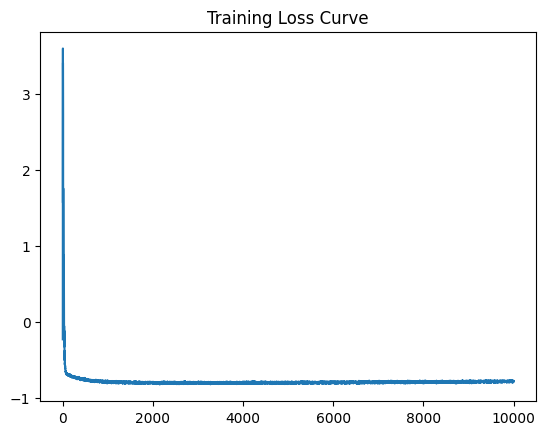

In [33]:
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

# Verification of generated pairing

In [51]:
from scipy import stats

ref_mnn = ref_crt_pcadata[pairs_train[:, 0]]
new_mnn = new_crt_pcadata[pairs_train[:, 1]]
mnn_corr = mnn_pval = torch.zeros(len(ref_mnn))
for i in range(len(ref_mnn)):
    mnn_corr[i] = stats.pearsonr(ref_mnn[i], new_mnn[i]).statistic
    # mnn_corr[i] = stats.spearmanr(ref_mnn[i], new_mnn[i]).correlation

plt.title('Pearson Correlation of MNN Pairs')
# plt.title('Spearman Correlation of MNN Pairs')
plt.scatter(np.arange(len(mnn_corr)), mnn_corr)
ref_mnn.shape

IndexError: index 6905 is out of bounds for axis 0 with size 5061

In [67]:
# ref_crt_pcadata[mnn_pair_ref_new_pair_indices[:, 0]]
# ref_mnn[0].shape
# stats.pearsonr(ref_mnn[0], new_mnn[0])
mnn_corr[0]= stats.pearsonr(ref_mnn[0], new_mnn[0]).statistic
mnn_corr[0]

tensor(0.8031)

In [60]:
np.sum((ref_crt_pcadata[mnn_pair_ref_new_pair_indices[:, 0]] - new_crt_pcadata[mnn_pair_ref_new_pair_indices[:, 1]]) / new_crt_pcadata[mnn_pair_ref_new_pair_indices[:, 1]] < 0.05) / 14129 / 400

0.7339924976997665

In [34]:
traj = recFlow.sample_ode(z0=np.arange(ref_crt_pcadata.shape[0]), N=1000)
recflow_descendant = traj[-1]

In [35]:
dot_sim = torch.matmul(recflow_descendant, torch.tensor(new_crt_pcadata.T))
cos_sim = dot_sim / torch.unsqueeze(torch.norm(recflow_descendant, p=2, dim=1), 1) / torch.unsqueeze(torch.norm(torch.tensor(new_crt_pcadata.T), p=2, dim=0), 0)

In [36]:
# time_pair = (days[index_pair[0]], days[index_pair[1]])
PATH_TMAP = 'tmaps/tmaps_0.0_0.5.h5ad'
# tmaps = wot.io.read_dataset("tmaps_" + "%.1f"%time_pair[0] + "_" + "%.1f"%time_pair[1]})
tmaps = wot.io.read_dataset(PATH_TMAP)
# seta = set(np.argsort(tmaps.X[0])[-50:])
# print(seta)

In [82]:
from scipy import stats

# result = stats.spearmanr(torch.tensor(tmaps.X), dot_sim, axis=1)
tensor_tmapX = torch.tensor(tmaps.X)
corrs = pvals = torch.zeros(ref_crt_pcadata.shape[0])
for i in range(ref_crt_pcadata.shape[0]):
    # corrs[i], pvals[i] = stats.spearmanr(tensor_tmapX[i], cos_sim[i])
    # corrs[i] = stats.spearmanr(tensor_tmapX[i], cos_sim[i]).correlation
    corrs[i] = stats.pearsonr(tensor_tmapX[i], cos_sim[i]).statistic
# tensor_tmapX[i].shape

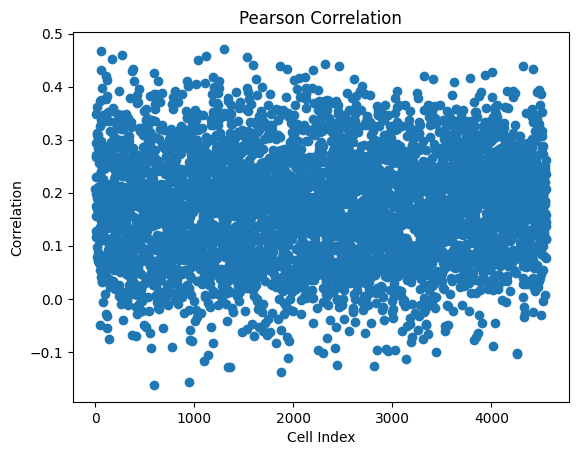

In [83]:
plt.xlabel('Cell Index')
plt.ylabel('Correlation')
plt.title('Pearson Correlation')
plt.scatter(np.arange(ref_crt_pcadata.shape[0]), corrs)

(array([  15.,   70.,  247.,  754.,  881., 1004.,  863.,  506.,  179.,
          37.]),
 array([-0.16226271, -0.09893847, -0.03561424,  0.02770999,  0.09103423,
         0.15435846,  0.21768269,  0.28100693,  0.34433118,  0.40765539,
         0.47097963]),
 <BarContainer object of 10 artists>)

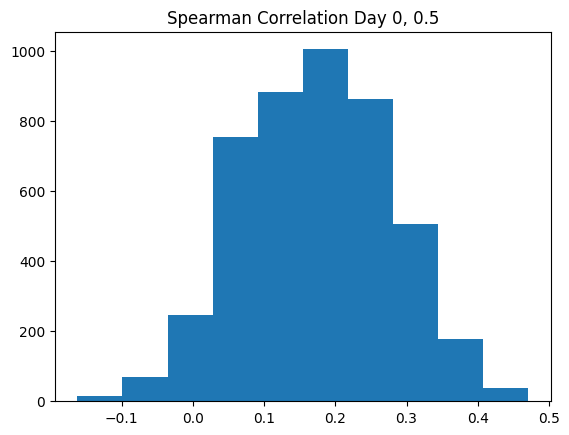

In [92]:
plt.title('Spearman Correlation Day 0, 0.5')
plt.hist(corrs)

(array([  15.,   70.,  247.,  754.,  881., 1004.,  863.,  506.,  179.,
          37.]),
 array([-0.16226271, -0.09893847, -0.03561424,  0.02770999,  0.09103423,
         0.15435846,  0.21768269,  0.28100693,  0.34433118,  0.40765539,
         0.47097963]),
 <BarContainer object of 10 artists>)

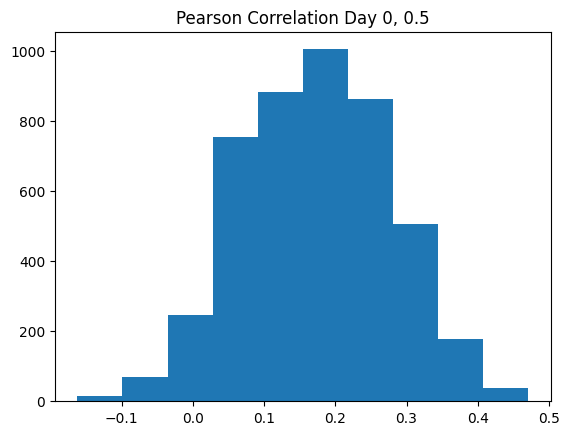

In [93]:
plt.title('Pearson Correlation Day 0, 0.5')
plt.hist(corrs)

# Co-training of flows over time

In [5]:
import utils
from utils import *
from rectifiedflow import *

# index_pair = (1, 2)
n_obs_list = [pcadatalist[i].shape[0] for i in range(len(pcadatalist))]
# intersection_1_2, unpaired_ref_cell_indices_1_2, unpaired_new_cell_indices_1_2 = NNVerification(index_pair)
# pairs_train_1_2, ref_crt_pcadata_1_2, new_crt_pcadata_1_2 = utils.gen_pairs_train(index_pair, n_obs_list, unpaired_ref_cell_indices_1_2, unpaired_new_cell_indices_1_2)
# iterations = 10000
# batchsize = 2048
# input_dim = 400

# recFlow = RectifiedFlow(index_pair=index_pair, n_obs_list=n_obs_list, model=MLP(input_dim=input_dim, hidden_num=1024), num_steps=1000)
# optimizer = torch.optim.Adam(recFlow.model.parameters(), lr=5e-3)

# recFlow, loss_curve = train_rectified_flow(recFlow, optimizer, pairs_train_1_2, batchsize, iterations)

In [5]:
recFlow_0_1, loss_curve_0_1 = recFlow, loss_curve

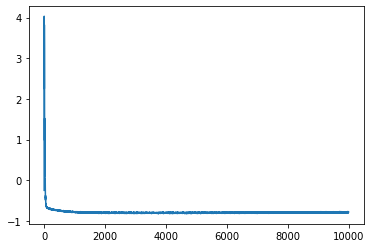

In [6]:
plt.plot(loss_curve_0_1)

In [6]:
hidden_dim_cand = [256, 512, 1024, 2048]
num_step_cand = [100, 1000, 10000]

index_pair = (0, 1)
# n_obs_list = [pcadatalist[i].shape[0] for i in range(len(pcadatalist))]
# intersection_0_1, unpaired_ref_cell_indices_0_1, unpaired_new_cell_indices_0_1 = NNVerification(index_pair)
# pairs_train_0_1, ref_crt_pcadata_0_1, new_crt_pcadata_0_1 = utils.gen_pairs_train(index_pair, n_obs_list, unpaired_ref_cell_indices_0_1, unpaired_new_cell_indices_0_1)
iterations = 10000
batchsize = 2048
input_dim = 400
recFlow_dict = {}
loss_curve_dict = {}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for hidden_dim in hidden_dim_cand:
    recFlow = RectifiedFlow(index_pair=index_pair, n_obs_list=n_obs_list, model=MLP(input_dim=input_dim, hidden_num=hidden_dim), num_steps=1000)
    optimizer = torch.optim.Adam(recFlow.model.parameters(), lr=5e-3)
    recflow, loss_curve = train_rectified_flow(recFlow, optimizer, pairs_train_0_1, batchsize, iterations)
    recFlow_dict[f'hidden_dim_{hidden_dim}'], loss_curve_dict[f'hidden_dim_{hidden_dim}'] = recflow, loss_curve
for num_step in num_step_cand:
    recFlow = RectifiedFlow(index_pair=index_pair, n_obs_list=n_obs_list, model=MLP(input_dim=input_dim, hidden_num=1024), num_steps=num_step)
    optimizer = torch.optim.Adam(recFlow.model.parameters(), lr=5e-3)

    recFlow_dict[f'num_step_{num_step}'], loss_curve_dict[f'num_step_{num_step}'] = train_rectified_flow(recFlow, optimizer, pairs_train_0_1, batchsize, iterations)


TypeError: RectifiedFlow.__init__() got an unexpected keyword argument 'index_pair'

In [10]:
import pickle

f = open('recFlow.pkl', "wb")
pickle.dump(recFlow_dict, f)
f.close()

AttributeError: Can't pickle local object 'MLP.__init__.<locals>.<lambda>'

/tmp/ipykernel_231940/1225791417.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dot_sim = torch.matmul(recflow_descendant, torch.tensor(new_crt_pcadata_0_1.T))
/tmp/ipykernel_231940/1225791417.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cos_sim = dot_sim / torch.unsqueeze(torch.norm(recflow_descendant, p=2, dim=1), 1) / torch.unsqueeze(torch.norm(torch.tensor(new_crt_pcadata_0_1.T), p=2, dim=0), 0)


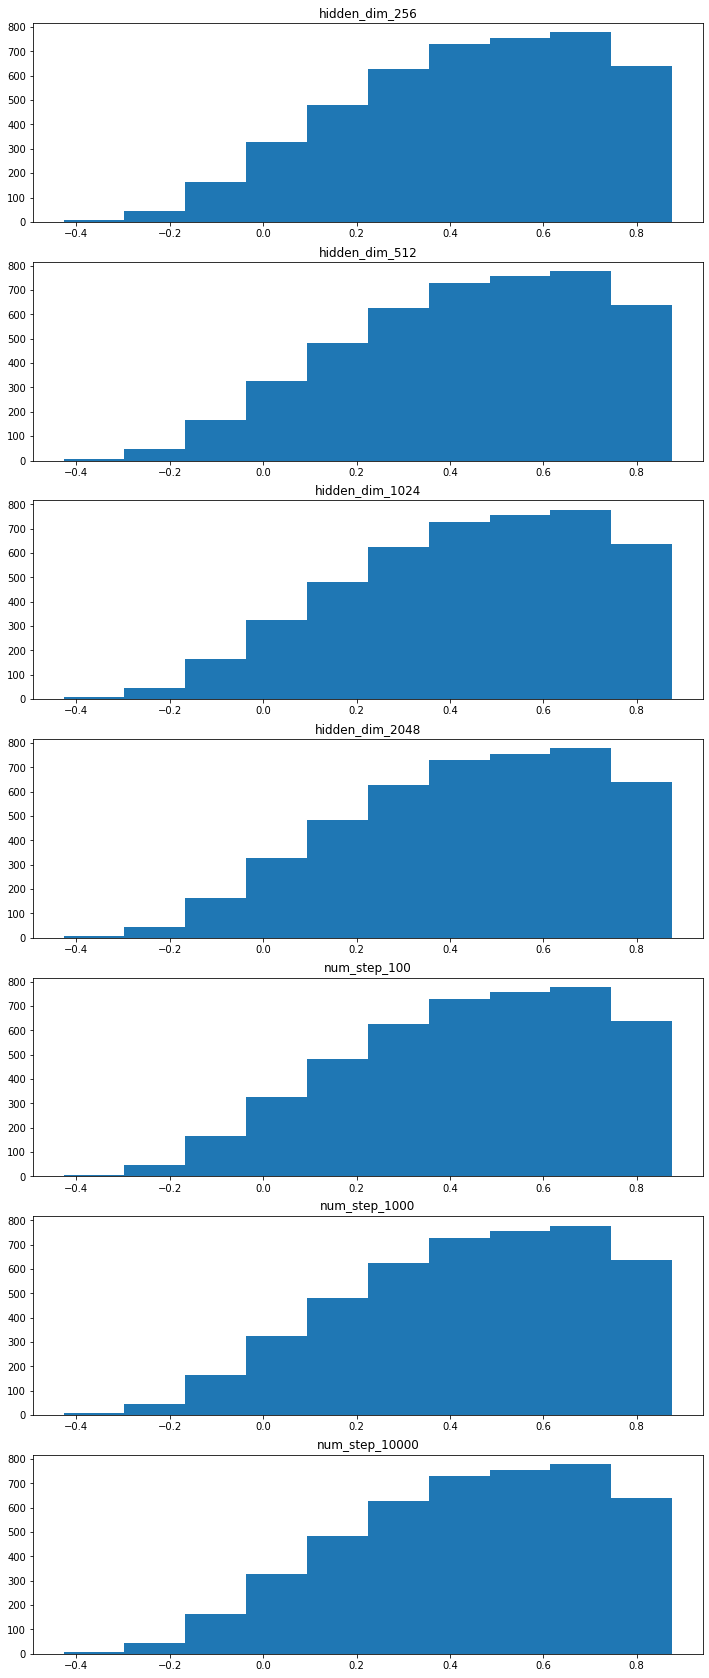

In [17]:
from scipy import stats

iter = 1
plt.figure(figsize=(12, 30))
# for key, item in loss_curve_dict.items():
#     plt.subplot(7, 1, i)
#     plt.title(key)
#     plt.plot(item)
#     i += 1
PATH_TMAP = 'tmaps/tmaps_0.0_0.5.h5ad'
tmaps = wot.io.read_dataset(PATH_TMAP)
tensor_tmapX = torch.tensor(tmaps.X)
# new_crt_pcadata_0_1 = new_crt_pcadata_0_1.cpu()

for key, item in recFlow_dict.items():
    traj = recFlow.sample_ode(z0=np.arange(ref_crt_pcadata_0_1.shape[0]), N=1000)
    recflow_descendant = traj[-1].cpu()
    dot_sim = torch.matmul(recflow_descendant, torch.tensor(new_crt_pcadata_0_1.T))
    cos_sim = dot_sim / torch.unsqueeze(torch.norm(recflow_descendant, p=2, dim=1), 1) / torch.unsqueeze(torch.norm(torch.tensor(new_crt_pcadata_0_1.T), p=2, dim=0), 0)
    corrs = torch.zeros(ref_crt_pcadata_0_1.shape[0])
    for i in range(ref_crt_pcadata_0_1.shape[0]):
        # corrs[i] = stats.pearsonr(tensor_tmapX[i], cos_sim[i]).statistic
        corrs[i] = stats.spearmanr(tensor_tmapX[i], cos_sim[i]).correlation
    plt.subplot(7, 1, iter)
    plt.title(key)
    plt.hist(corrs)
    iter += 1
    

In [86]:
intersection_list = unpaired_ref_cells_list = unpaired_new_cells_list = []
for index in range(len(days) - 1):
    intersection, unpaired_ref_cells, unpaired_new_cells = NNVerification(index_pair=(index, index + 1))
    intersection_list.append(intersection)
    unpaired_ref_cells_list.append(unpaired_ref_cells)
    unpaired_new_cells_list.append(unpaired_new_cells)
    np.count_nonzero(intersection > 0.5) / len(intersection)
    

Time pair: day 0.0, day 0.5
4556
3449
Average intersection ratio: 0.7094773728284611
Time pair: day 0.5, day 1.0
3449
3648
Average intersection ratio: 0.6392277810012297
Time pair: day 1.0, day 1.5
3648
1956
Average intersection ratio: 0.7074328345660762
Time pair: day 1.5, day 2.0
1956
6981
Average intersection ratio: 0.8326937497787211
Time pair: day 2.0, day 2.5
6981
6734
Average intersection ratio: 0.8048882848167077
Time pair: day 2.5, day 3.0
6734
6777
Average intersection ratio: 0.7245922796804378
Time pair: day 3.0, day 3.5
6777
7355
Average intersection ratio: 0.8905577593369152
Time pair: day 3.5, day 4.0
7355
8962
Average intersection ratio: 0.7481793077940243
Time pair: day 4.0, day 4.5
8962
7127
Average intersection ratio: 0.7264315371983588
Time pair: day 4.5, day 5.0
7127
7227
Average intersection ratio: 0.880552093526264
Time pair: day 5.0, day 5.5
7227
6550
Average intersection ratio: 0.9476326820431032
Time pair: day 5.5, day 6.0
6550
8422
Average intersection ratio: 

In [7]:
from utils import *
from rectifiedflow import *

index_pair_list = [(i, i + 1) for i in range(15)]
# days[index_pair_list]
n_obs_list = [pcadatalist[i].shape[0] for i in range(len(pcadatalist))]
pairs_train = None

for index_pair in index_pair_list:
    intersection, unpaired_ref_cell_indices, unpaired_new_cell_indices = NNVerification(index_pair)
    tmp_pairs_train, ref_crt_pcadata, new_crt_pcadata = gen_pairs_train(index_pair, n_obs_list, unpaired_ref_cell_indices, unpaired_new_cell_indices)
    if pairs_train is None:
        pairs_train = torch.tensor(tmp_pairs_train)
        pairs_train = torch.concat((pairs_train, torch.tensor([index_pair[0], index_pair[1]]).repeat(tmp_pairs_train.shape[0], 1)), 1)
    else:
        tmp_pairs_train = torch.concat((tmp_pairs_train, torch.tensor([index_pair[0], index_pair[1]]).repeat(tmp_pairs_train.shape[0], 1)), 1)
        pairs_train = torch.concat((pairs_train, tmp_pairs_train), 0)

Loading from pcadata/0_1.csv
Loading from pcadata/pcadata_contiguous_0_1.npy


KeyboardInterrupt: 

In [7]:
from utils import *
from rectifiedflow import *

index_pair_list = [(i, i + 1) for i in range(15)]
# days[index_pair_list]
n_obs_list = [pcadatalist[i].shape[0] for i in range(len(pcadatalist))]

iterations = 2000
batchsize = 2048
input_dim = 400
hidden_dim = 256
recFlow_dict = {}
loss_curve_dict = {}
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
pairs_train = torch.load('pairs_train.pt')
recFlow = RectifiedFlow(n_obs_list=n_obs_list, model=MLP(input_dim=input_dim, hidden_num=hidden_dim), num_steps=1000, reverse=False)
optimizer = torch.optim.Adam(recFlow.model.parameters(), lr=5e-3)
recflow, loss_curve = train_rectified_flow(recFlow, optimizer, pairs_train, batchsize, iterations)
# recFlow_dict[f'hidden_dim_{hidden_dim}'], loss_curve_dict[f'hidden_dim_{hidden_dim}'] = recflow, loss_curve


100%|██████████| 2001/2001 [06:14<00:00,  5.35it/s]


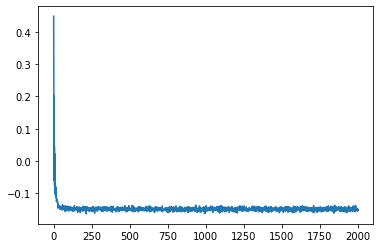

In [9]:
plt.plot(loss_curve)

In [10]:
# target = recflow.simulate_target(z0=torch.arange(3815), zid=16, N=1000)
target = recflow.simulate_target(z0=torch.arange(5061), zid=15, N=1000)

In [11]:
target.shape

torch.Size([3815, 400])

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   2.,   0.,   1.,   0.,   4.,   0.,   3.,   4.,   8.,   6.,
          4.,   5.,   9.,   3.,   6.,   8.,  10.,  11.,   7.,   9.,  14.,
          8.,  16.,  15.,  20.,  15.,  30.,  16.,  19.,  26.,  28.,  29.,
         31.,  30.,  23.,  41.,  37., 

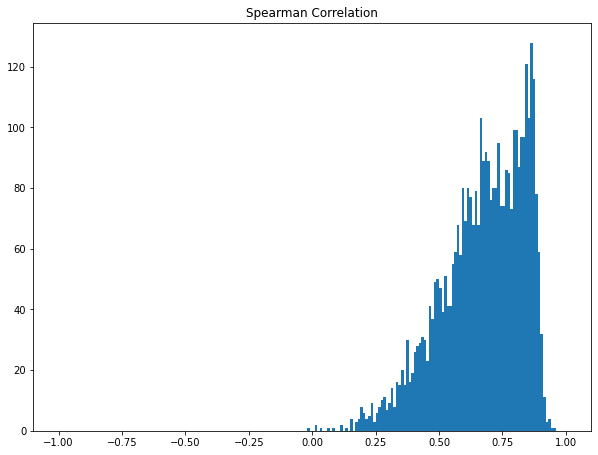

In [16]:
from scipy import stats

test_crt_pcadatapair = np.load('pcadata/pcadata_contiguous_15_16.npy', allow_pickle=True)[0]
ref_crt_pcadata = test_crt_pcadatapair[:n_obs_list[15]]
new_crt_pcadata = test_crt_pcadatapair[n_obs_list[15]:]

# n_neighbors = 50
# KNN = nb.NearestNeighbors(n_neighbors=n_neighbors)
# KNN.fit(ref_crt_pcadata)

PATH_TMAP = 'tmaps/tmaps_7.5_8.0.h5ad'
tmaps = wot.io.read_dataset(PATH_TMAP)
tensor_tmapX = torch.tensor(tmaps.X)
target = target.cpu()

# dot_sim = torch.matmul(torch.tensor(ref_crt_pcadata), target.cpu().T)
# cos_sim = dot_sim / torch.unsqueeze(torch.norm(target.cpu(), p=2, dim=1), 0) / torch.unsqueeze(torch.norm(torch.tensor(ref_crt_pcadata.T), p=2, dim=0), 1)
dot_sim = torch.matmul(torch.tensor(new_crt_pcadata), target.cpu().T)
cos_sim = dot_sim / torch.unsqueeze(torch.norm(target.cpu(), p=2, dim=1), 0) / torch.unsqueeze(torch.norm(torch.tensor(new_crt_pcadata.T), p=2, dim=0), 1)
corrs = torch.zeros(new_crt_pcadata.shape[0])
# cvrg = torch.zeros(new_crt_pcadata.shape[0])
# print(tensor_tmapX.shape)
# print(dot_sim.shape)
for i in range(new_crt_pcadata.shape[0]):
    # ind_seq = tensor_tmapX[:, i].argsort()[-200:]
    # corrs[i] = stats.pearsonr(tensor_tmapX[:, i][ind_seq], dot_sim[i][ind_seq]).statistic
    # corrs[i] = stats.pearsonr(tensor_tmapX[:, i], torch.softmax(dot_sim[:, i], 0)).statistic
    # corrs[i] = stats.pearsonr(torch.nan_to_num(torch.log(tensor_tmapX[:, i])), cos_sim[:, i]).statistic
    # corrs[i] = stats.spearmanr(tensor_tmapX[:, i][ind_seq], cos_sim[:, i][ind_seq]).correlation
    corrs[i] = stats.spearmanr(tensor_tmapX[:, i], cos_sim[i, :]).correlation
    # _, indices = KNN.kneighbors(target[i].reshape(1, -1))
    # summation = tensor_tmapX[:, i][indices].sum()
    # cvrg[i] = summation / tensor_tmapX[:, i].sort()[0][-n_neighbors:].sum()
    
    
plt.figure(figsize=(10, 7.5))
plt.title('Spearman Correlation')
# plt.title(f'Coverage when n = {n_neighbors}')
# plt.title('Pearson Correlation between Cosine Similarity and Transition MAP')
plt.hist(corrs, bins=np.linspace(-1, 1, 201, endpoint=True))

# plt.scatter(torch.log(tensor_tmapX[:, 0]), dot_sim[:, 0])

# ind_seq = torch.argsort(tensor_tmapX[0])[-50:]
# tensor_tmapX[0][ind_seq]

# plt.xlabel('TMAP')
# plt.ylabel('Cosine Similarity')
# plt.scatter(torch.log(tensor_tmapX[0]), cos_sim[0])


In [135]:
# tensor_tmapX[:, 0].sort()[0][-500:].sum() / tensor_tmapX[:, 0].sum()
tensor_tmapX[:, 0].argsort()[-50:]

tensor([2657, 3714, 4029, 3879, 4321,   42, 2735, 4739, 4592, 4152, 1155, 1700,
        3365, 3645, 4345, 1068, 4981, 4913, 1273, 1509, 4103, 4220, 1132, 3548,
        3807, 3273, 4562, 3064, 4794, 4855, 2695, 4947, 3362, 2376, 2083, 4967,
         650, 3253, 1376, 4522, 2921, 2850, 3292, 5025, 2299, 5029, 4308, 3003,
        4793, 4559])

In [21]:
import wot
import torch

PATH_TMAP = 'tmaps/tmaps_6.5_7.0.h5ad'
tmaps = wot.io.read_dataset(PATH_TMAP)
tensor_tmapX = torch.tensor(tmaps.X)
summation = []
for i in tensor_tmapX.sum(dim=0):
    # print(i.item(), end=' ')
    summation.append(i.item())
torch.mean(torch.tensor(summation))
# tensor_tmapX.shape

tensor(0.4719)

In [24]:
torch.tensor(summation).shape

torch.Size([6507])

In [25]:
# tensor_tmapX.shape[0] / tensor_tmapX.shape[1]
tensor_tmapX.shape

torch.Size([3111, 6507])

In [32]:
n_obs_list

[4556,
 3449,
 3648,
 1956,
 6981,
 6734,
 6777,
 7355,
 8962,
 7127,
 7227,
 6550,
 8422,
 3111,
 6507,
 5061,
 3815,
 7666,
 6400,
 6319,
 5016,
 3849,
 3931,
 3396,
 3579,
 3543,
 3868,
 3610,
 3443,
 3637,
 7594,
 6849,
 8199,
 12416,
 9613,
 11455,
 8110,
 8118,
 7436]

# Prediction of next-generation cells' gene expression

In [232]:
# corrs.mean()
torch.count_nonzero(corrs > 0.5)

tensor(199)

In [193]:
# result.correlation[4556:, :4556]

array([[ 0.75626588, -0.32231061, -0.44213074, ..., -0.36190041,
        -0.27184065,  0.19389442],
       [ 0.55246427, -0.03178462, -0.1660723 , ...,  0.02851433,
        -0.23454934,  0.03049706],
       [ 0.58919827, -0.3392671 , -0.39838638, ..., -0.42386514,
        -0.24154552,  0.14067533],
       ...,
       [ 0.48676285, -0.09629973, -0.08846874, ...,  0.13355931,
        -0.16051258, -0.01693643],
       [ 0.6189222 , -0.36613407, -0.31705721, ..., -0.31431018,
        -0.11741903,  0.13583395],
       [ 0.69692586, -0.34581767, -0.482847  , ..., -0.43996315,
        -0.28197565,  0.20591193]])

In [189]:
result.correlation.shape

(9112, 9112)

In [136]:
tc = tmaps.X[0].copy()
temp = np.sort(tc)[-50:].sum()/tmaps.X[0].sum()
temp

0.6709378

In [146]:
KNN_new_rec = nb.NearestNeighbors(n_neighbors=50)
KNN_new_rec.fit(pcadatalist[index_pair[1]])
dists, indices = KNN_new_rec.kneighbors([np.array(recflow_descendant[0])])
setb = set(indices.squeeze())
print(setb)

{769, 2564, 2439, 3342, 3218, 2710, 664, 800, 33, 930, 3363, 292, 1407, 1064, 2425, 555, 2348, 2740, 2742, 2232, 2236, 2365, 1086, 446, 2497, 835, 451, 1733, 845, 718, 213, 86, 1111, 601, 858, 219, 1882, 2397, 606, 1761, 993, 1124, 1380, 1382, 237, 750, 1017, 762, 2301, 255}


In [149]:
intersect_len = []
for i in trange(pcadatalist[index_pair[0]].shape[0]):
    seta = set(np.argsort(tmaps.X[i])[-50:])
    dists, indices = KNN_new_rec.kneighbors([np.array(recflow_descendant[i])])
    setb = set(indices.squeeze())
    intersect_len.append(len(seta & setb))
np.average(np.array(intersect_len))

100%|██████████| 4556/4556 [00:18<00:00, 244.93it/s]


5.11369622475856

In [151]:
np.var(intersect_len)

25.008144283488825

In [127]:
# torch.tensor([pcadatalist[0][0]])
# loss_curve
# pairs_train.shape[0]
seta & setb

{555, 606, 718, 750, 858, 1382, 2497, 2742, 3342}

In [40]:
# recFlow.model(torch.tensor([pcadatalist[0][0]]), torch.tensor([[0]]))

tensor([[-1.1279, -0.0635, -1.0947,  0.2529, -0.5282, -3.0421,  0.5110, -1.8907,
         -0.0522, -1.0012,  1.8089, -0.7958,  0.1271, -1.0385,  0.2367,  0.3067,
         -1.2648, -1.7070, -3.0288, -0.1463, -1.0794,  1.8206, -0.0108, -0.5595,
          0.8891,  0.0247,  1.1246, -0.7822,  0.7860,  0.0812, -0.6976, -1.1193,
          0.1411,  1.1246,  0.2163, -1.6749,  0.2797, -0.0801, -1.6234, -0.2709,
         -0.0462, -0.4291,  0.4798,  0.4132, -0.1353, -0.1982, -0.9799,  0.3786,
         -0.2610, -0.3199,  0.4718, -1.1137,  0.2410, -1.0545,  0.5243,  0.1466,
          0.5894,  0.9240, -0.0803, -0.4891,  0.2107, -0.1577, -0.4489,  0.1165,
          0.6100, -0.2526, -0.4202,  0.8129, -0.0058, -0.1387, -0.4763, -0.6492,
         -0.9908,  0.4196,  0.3735, -0.8149, -1.8083,  0.4048, -0.2521,  0.6571,
          0.3433, -1.5761,  0.0275,  0.4470, -0.1780, -0.6525, -0.5341, -0.2866,
         -0.0960,  0.4099,  0.7390,  0.0285,  0.2668,  0.9762, -0.0549,  0.4303,
          1.5326,  0.1330,  

In [147]:
# KNN_ref = nb.NearestNeighbors(n_neighbors=50)
# KNN_new = nb.NearestNeighbors(n_neighbors=50)

# KNN_ref.fit(pcadatalist[0])
# KNN_new.fit(pcadatalist[1])

NearestNeighbors(n_neighbors=50)

In [ ]:
# ref_cell_index = np.arange(adata_ref.n_obs)
# new_cell_index = np.arange(adata_new.n_obs)
# # indices of K neighbors of new cell
# dist_new, ind_neighbour_new = KNN_ref.kneighbors(adata_new.X)
# # indices of K neighbors of ref cell
# dist_ref, ind_neighbour_ref = KNN_new.kneighbors(adata_ref.X)

# paired_ref = mnn_1415['ref cell'].unique().sort()
# paired_new = mnn_1415['new cell'].unique().sort()

In [15]:
# Pair Initialization

# ref_cell_index = np.arange(adata_ref.n_obs)
# new_cell_index = np.arange(adata_new.n_obs)
# # indices of K neighbors of new cell
# dist_new, ind_neighbour_new = KNN_ref.kneighbors(adata_new.X)
# # indices of K neighbors of ref cell
# dist_ref, ind_neighbour_ref = KNN_new.kneighbors(adata_ref.X)

# paired_ref = mnn_1415['ref cell'].unique().sort()
# paired_new = mnn_1415['new cell'].unique().sort()

# unpaired_ref = np.where(ref_cell_index in paired_ref, None, ref_cell_index)
# np.mask_indices()
# knn_init_neighbor_ref = np.array([ind_neighbour_ref[i] for i in ref_cell_index and i not in paired_ref])

In [43]:
# adata_ref.obs_names_make_unique
# adata_ref.n_obs
# unpaired_ref = [i for i in ref_cell_index if i not in paired_ref]
# unpaired_new = [j for j in new_cell_index if j not in paired_new]
# knn_init_neighbour_ref = ind_neighbour_ref[unpaired_ref]
# knn_init_neighbour_new = ind_neighbour_new[unpaired_new]

In [44]:
# knn_init_neighbour_new.shape

(4242, 50)

In [133]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from tqdm import trange

# class MLP(nn.Module):
#     def __init__(self, input_dim=19089, hidden_num=1024):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
#         self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
#         self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
#         self.act = lambda x: torch.tanh(x)
    
#     def forward(self, x_input, t):
#         inputs = torch.cat([x_input, t], dim=1)
#         x = self.fc1(inputs)
#         x = self.act(x)
#         x = self.fc2(x)
#         x = self.act(x)
#         x = self.fc3(x)

#         return x

In [128]:
# class RectifiedFlow():
#     def __init__(self, model=None, num_steps=1000, adata_active=True):
#         self.model = model
#         self.N = num_steps
#         self.adata_active = adata_active
    
#     def get_train_tuple(self, z0=None, z1=None):
#         t = torch.rand((z1.shape[0], 1))
#         # print(t.shape)
#         # print(z1.shape)
#         if self.adata_active:
#             z1 = torch.Tensor(adata_new.X[z1].toarray())
#             z0 = torch.Tensor(adata_ref.X[z0].toarray())
#         # print(z1.shape)
#         # print(t.shape)
#         # print(t * z1)
#         z_t =  t * z1 + (1. - t) * z0
#         target = z1 - z0 
            
#         return z_t, t, target

#     @torch.no_grad()
#     def sample_ode(self, z0=None, N=None):
#         ### NOTE: Use Euler method to sample from the learned flow
#         if N is None:
#             N = self.N    
#         dt = 1./N
#         traj = [] # to store the trajectory
#         z = z0.detach().clone()
#         batchsize = z.shape[0]
        
#         traj.append(z.detach().clone())
#         for i in range(N):
#             t = torch.ones((batchsize,1)) * i / N
#             pred = self.model(z, t)
#             z = z.detach().clone() + pred * dt
            
#             traj.append(z.detach().clone())

#         return traj

In [129]:
# def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
#     loss_curve = []
#     for i in trange(inner_iters+1):
#         optimizer.zero_grad()
#         indices = torch.randperm(len(pairs))[:batchsize]
#         batch = pairs[indices]
#         z0 = batch[:, 0].detach().clone()
#         z1 = batch[:, 1].detach().clone()
#         z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

#         pred = rectified_flow.model(z_t, t)
#         loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
#         loss = loss.mean()
#         loss.backward()
        
#         optimizer.step()
#         loss_curve.append(np.log(loss.item())) ## to store the loss curve

#     return rectified_flow, loss_curve

In [130]:
# # mnn_1415
# pairs_idx = torch.from_numpy(np.stack((mnn_1415['ref cell'], mnn_1415['new cell']), axis=0)).T
# # pairs_idx.t

# # knn_pairs_idx = 
# unpaired_new_row = torch.from_numpy(np.stack((unpaired_new, unpaired_new), axis=0)).T.reshape(-1, 1)
# unpaired_nb_new = torch.from_numpy(knn_init_neighbour_new[:, :2]).reshape(-1, 1)
# unpaired_ref_row = torch.from_numpy(np.stack((unpaired_ref, unpaired_ref), axis=0)).T.reshape(-1, 1)
# unpaired_nb_ref = torch.from_numpy(knn_init_neighbour_ref[:, :2]).reshape(-1, 1)

# ind_knn_new = torch.concat((unpaired_nb_new, unpaired_new_row), dim=1)
# ind_knn_ref = torch.concat((unpaired_ref_row, unpaired_nb_ref), dim=1)

# pair_idx_train = torch.concat((pairs_idx, ind_knn_new, ind_knn_ref), axis=0)

Training

In [141]:
# # pair_idx_train.shape

# iterations = 1000
# batchsize = 2048
# input_dim = 19089

# recFlow = RectifiedFlow(MLP(input_dim=input_dim, hidden_num=128), num_steps=100)
# optimizer = torch.optim.Adam(recFlow.model.parameters(), lr=5e-3)

# recFlow, loss_curve = train_rectified_flow(recFlow, optimizer, pair_idx_train, batchsize, iterations)

  0%|          | 2/1001 [00:04<37:59,  2.28s/it]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Training Loss Curve')

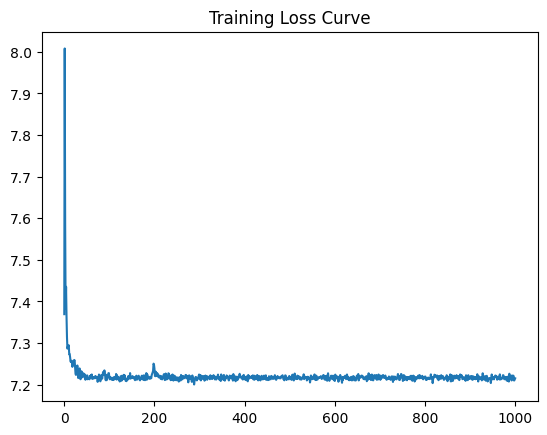

In [137]:
# plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
# plt.title('Training Loss Curve')

In [140]:
# # pair_idx_train.shape

# iterations = 1000
# batchsize = 2048
# input_dim = 19089

# recFlow1415 = RectifiedFlow(MLP(input_dim=input_dim, hidden_num=1024), num_steps=100)
# optimizer = torch.optim.Adam(recFlow1415.model.parameters(), lr=5e-3)

# recFlow1415, loss_curve = train_rectified_flow(recFlow1415, optimizer, pair_idx_train, batchsize, iterations)

  0%|          | 2/1001 [00:13<1:53:55,  6.84s/it]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Training Loss Curve')

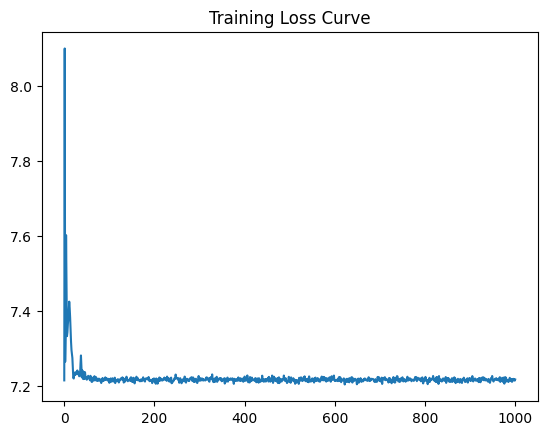

In [139]:
# plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
# plt.title('Training Loss Curve')

In [ ]:
# adpair_242526 = wot.io.read_dataset(PATH_adpair_242526)
# mnn_242526 = pd.read_csv(PATH_mnn_242526)


